This page details the NeutralizationBench.py module. 

This is use to simulate reactions between any given number of antigens and antibodies. 
It works on the assumption that a given antibody attaches to only a single site
on the virus. It has two stages of calculation:

Stage 1: Assuming that antigenic sites and antibodies are like chemical reagents in a 
solution the system numerically solves a system of differential equations given by the
following chemical reactions:

    [V_jAb_I] + [Ab_i] <=> [V_jAb_I2]

Here V_j represents the antigenic sites on virus j, Ab_i represents antibody i,
V_jAb_I represents the complex formed between virus j's antigenic sites and the
collection of antibodies given by the multi-index I. [ ] represents molar concentration at 
the time of interest. When we want to include the time variable, we show it by [V_j(t)] etc.
If I = empty then V_jAb_I = V_j. In the case I=empty then we just have the usual equation

	[V_j] + [Ab_i] <=> [V_jAb_i]

Once this equation is solved at some t the quantity [V_j(t)]/[V_j(0)] represents the fraction
of free antigenic sites of virus j. For simplicity we will simply refere to these sites as
virus j.

Although by a very rough estimate one might take this to be
representative of the remaining active viruses, the more correct way is to include a stage 2
probabilistic calculation as described below.

Stage 2: Assume [V_j(t)]/[V_j(0)]=0.99. This means that 0.99 proportion of the totality of all 
antigenic sites in the solution are still free. How can you translate this into proportion of active
viruses? For this we need to set the following parameter: The number of antigenic sites on a single virus.
Lets assume it is 150 (roughly the number of HA molecules). Then the expected number of bound sites
on this virus is 150\*0.01 = 1.5. Ofcourse this is the expected value and one might assume a distribution
of values around this mean. To get the fraction of viruses which have all their sites free, one can simply
compute 0.99^150 = 0.22. Those which have only one antibody bound would be 0.99^149 * 0.01 = 0.002 and so on. 
Therefore only about 0.22 percent of all the viruses would be completely free of any antibodies (which could
be expected since the expected number of antibodies bound to each virus is ~1 which suggests this is more likely
than no bound). Now we have to set the second parameter: "How many antibodies are required for inactivation of a virus". Once this is set, then one can compute the proportion of viruses as above which have less bound antibodies
then this threshold and compute the proportion of active viruses. By some work, this can actually be
extended to multiple types of antibodies with different inactivation thresholds but due to the length of the exposition the details are not shown here.

Parameters:

The reaction in stage 1 is regulated by two rates the association rate (or k(j,I,i)
and the dissociation rate b(j,I,i). k(j,I,i) for instance represents the rate 
of attachment of antibody i to the complex formed by virus j + antibodies I.
As another example k(j,empty,i) would be the rate of attachment of antibody i 
to the virus j (since I=empty means no antibodies are attached to virus).
In such a case, for simplicity we will shows these rates by k(j,i) and drop the empty.
Similarly for b.

If different antibodies dont interfere with each other then k(j,I,i)=k(j,i) 
for any I.

The main inputs to this machinery are therefore the the rates k(j,I,i) and b(j,I,i).
We can make some simplifying assumptions in determination of these rates 
as k(j,I,i) as it stands out could be alot of rates since I is any combination 
of antigen indices in any number.

To start with for simpilicity one can assume b(j,I,i) = b(j,i), that is there is no interference
for dissociation rate. We also assume association rates can be represented as:

	k(j,I,i)=k(j,i)*interference(j,I,i)
	
This means that k(j,I,i) equals to original rate of attachment of antigen i to
virus j times an interference term due to antibodies I being bound to virus j.
	
Moreover if I=(i1,...,in) then 

	interference(j,I,i)= interference(j,i1,i)*interference(j,i2,i)*...*interference(j,in,i)
	
This is to say interference due to different antibodies being bound to the virus j
are independent of each other. If all interference rates are 1 then it means that antibodies
dont interefere with each other, if they are all 0 then binding of one antibody
completely prevents the others.	

For the combinatorial stage one has to input the maximum number of antigenic sites
on a virus (default 150) and number of bound antibodies required for each antibody to
neutralize a virus (default 6).

With these simplifications the rates one needs to determine are as follows:

Given a virus j and antibodies i1,...,in, you have to determine the association 
rates k(j,i), dissociation rates b(j,i) and the intereference between each 
antibody interference(j,k1,k2) where k1,k2 = i1,...,in. 

Various literature suggest that association rates of antibodies against hemaglutinnin (in various
different setups) range between 1e5 to 1e6 1/Ms where M is molars ad s is seconds and dissociation rates vary between 1e-5 to 1e-3 1/s ([1] Figure 4, [2] Figure 3, [3], Table 1). Binding affinity which the ratio of association and dissociation rates is between 1e8 to 1e10 1/M ([2] Figure 3). 

There other inputs required such as the initial concentration of antigenic binding sites
and initial concentration of antibodies. Number of antigenic sites can be calculated
as PFUs x particle_to_PFU_ratio x max_number_of_sites. A rough estimate for the antibody concentration
was determined by using the FRA experiments recently done in Erasmus. 

One also needs to input which serial dilutions of sera are used for neutralization and 
the neutralization time. See the example code below for further details.

[1] 'Sequential Seasonal H1N1 Influenza Virus Infections Protect Ferrets
against Novel 2009 H1N1 Influenza Virus', Carter, D.M. et al.

[2] 'The Breadth of Cross Sub-Type Neutralisation Activity of
a Single Domain Antibody to Influenza Hemagglutinin
Can Be Increased by Antibody Valency', Hufton, S.E. et al. 

[3] 'Heterosubtypic Antibodies to Influenza A Virus Have Limited Activity against Cell-Bound Virus but Are Not Impaired by Strain-Specific Serum Antibodies', Wyrzucki A. et al.

We start by given an example of what kind of equations this package generates. Consider 
a system with 1 antigen and 3 antibodies. We will use the _systemOfEquations function
with print_equations=True. This function is normally called from titrateAntigensAgainstSera
which what the user will be using to get the neutralization and titer curves (you can also
supply print_equations option to this function). For the purposes of this demonstration,
we set association and dissociation constants to be 2 and 1 respectively so their position
in the equatios are evident.

In [1]:
import sys
import numpy as np
from NeutralizationBench import _systemOfEquations,titrateAntigensAgainstSera, outputScatterPlot, outputTiterCurvePlot

number_of_antigens = 1
number_of_antibodies = 2

association_rates = 2 * np.ones((number_of_antigens, number_of_antibodies))
dissociation_rates = np.ones((number_of_antigens, number_of_antibodies))
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))    

ode, variables = _systemOfEquations(
    number_of_antigens, number_of_antibodies, association_rates, dissociation_rates,
    interference_matrix, print_equations=True)   


System of equations is:

0- d[V0]/dt=-2.0*Ab_0*V0 - 2.0*Ab_1*V0 + 1.0*V0Ab_0 + 1.0*V0Ab_1

1- d[Ab_0]/dt=-2.0*Ab_0*V0 - 2.0*Ab_0*V0Ab_1 + 1.0*V0Ab_0 + 1.0*V0Ab_0_1

2- d[Ab_1]/dt=-2.0*Ab_1*V0 - 2.0*Ab_1*V0Ab_0 + 1.0*V0Ab_0_1 + 1.0*V0Ab_1

3- d[V0Ab_0]/dt=2.0*Ab_0*V0 - 2.0*Ab_1*V0Ab_0 - 1.0*V0Ab_0 + 1.0*V0Ab_0_1

4- d[V0Ab_1]/dt=-2.0*Ab_0*V0Ab_1 + 2.0*Ab_1*V0 + 1.0*V0Ab_0_1 - 1.0*V0Ab_1

5- d[V0Ab_0_1]/dt=2.0*Ab_0*V0Ab_1 + 2.0*Ab_1*V0Ab_0 - 2.0*V0Ab_0_1



Below we test how the inactivation threshold affects the behaviour of the titer curve.

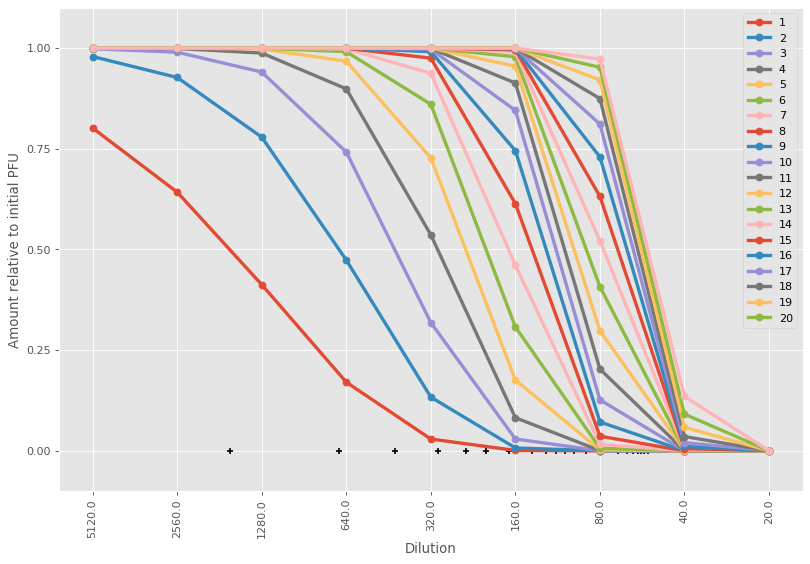

In [26]:
import matplotlib.pyplot as plt

number_of_antigens = 1
number_of_antibodies = 1
M = 6e23
particle_to_pfu_ratio = 50
nspikes = 150
total_volume = 1e-4
total_antibody = 600 * 5e9


#we try with all the inactivaton thresholds  = 1 to 20 (i.e 1 to 20 antibodies enough to neutralize a virus)
association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 0.5e5 / M
dissociation_rates = 1e-4 ** np.ones((number_of_antigens, number_of_antibodies))
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))

total_PFU = 100

fig, ax = plt.subplots(1,1,figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

init_vals = [total_PFU * particle_to_pfu_ratio * nspikes / total_volume , total_antibody / total_volume]


measurement_time = 3600
dilutions=1/np.array([5120,2560,1280,640,320,160,80,40,20])

for i in range(21):
    y, log_titer, titer, _ = titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, inactivation_thresholds = [i+1])   

    ax, fig = outputTiterCurvePlot(y, log_titer, number_of_antigens, dilutions, fig=fig, ax=ax)

ax.set_ylabel('Amount relative to initial PFU')
ax.set_xlabel('Dilution')
ax.legend(range(1,21));



It seems as though when threshold = 1 the titer curve drops too slowly compared to experimental FRA titer curves
so a higher value might be more correct. It would seem that curves start looking more like regular FRA titer curves after threshold values around 5-6 and anything beyond 8 seems to steep.

We now test how titers are mixed. Assume we have to antibody solutions with concentrations c1 and c2.

In case one, we first get the titer curves for two antibodies individually and then for sera containing them
mixed in 0.5*c1 and 0.5*c2 concentrations. This corresponds to the case of titrating a virus agains two antibody
solutions first and then making a new solution by taking half of each of the initial solution.

In case two, we again have two antibodoes but we mix them by adding them together (i.e mixed together in 
concentrations c1 and c2). This case corresponds to using an assay that measures HA and NA antibody titers
seperately and then together.
                                                                                  


Titers are respectively [240], [49], [141].
Arithmetic mean of first two titers is 144.5.


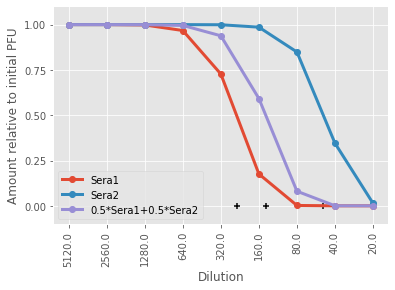

In [12]:
#testing individual sera vs combined sera

#sera1
number_of_antigens = 1
number_of_antibodies = 1


association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 0.5e5 / M
dissociation_rates = 1e-4 ** np.ones((number_of_antigens, number_of_antibodies))
total_antibody = 600 * 5e9
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))
total_PFU = 1000

init_vals = [total_PFU * particle_to_pfu_ratio * nspikes / total_volume, total_antibody / total_volume]


ax1 = None
fig1 = None
ax2 = None
fig2 = None

y1, log_titer1, titer1, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, inactivation_thresholds = [5])  

ax1, fig1 = outputTiterCurvePlot(y1, log_titer1, number_of_antigens, dilutions, fig=fig1, ax=ax1)

ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')

#sera 2
association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 0.1e5 / M

y2, log_titer2, titer2, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, inactivation_thresholds = [5])   

ax1, fig1 = outputTiterCurvePlot(y2, log_titer2, number_of_antigens, dilutions, fig=fig1, ax=ax1)
ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')


#combined 0.5sera1 + 0.5sera2
number_of_antigens = 1
number_of_antibodies = 2

association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 0.1e5 / M
association_rates[0,1] = 0.5e5 / M
dissociation_rates = 1e-4 ** np.ones((number_of_antigens, number_of_antibodies))
total_antibody = 600 * 5e9
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))
total_PFU = 1000

init_vals = [total_PFU * particle_to_pfu_ratio * nspikes / total_volume, 0.5 * total_antibody / total_volume,
             0.5 * total_antibody / total_volume]


y3, log_titer3, titer3, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, inactivation_thresholds = [5,5])    

ax1, fig1 = outputTiterCurvePlot(y3, log_titer3, number_of_antigens, dilutions, fig=fig1, ax=ax1)

ax1.legend(['Sera1', 'Sera2', '0.5*Sera1+0.5*Sera2'])

print('Titers are respectively {}, {}, {}.'.format(titer1,titer2,titer3))
print('Arithmetic mean of first two titers is {}.'.format((titer1[0]+titer2[0]) * 0.5))



We see that in the first case, the mixed titer is somewhere between the first two. The value is quite close to arithmetic mean. More tests will be performed to see if this is true for more cases (with different mixing proportions). 